## Nevado del Ruiz

In [8]:
from seismoly import window,descrp #2 funciones propias hechas para segmentar la señal y para sacar los descriptores
from numpy import dot 
from numpy.linalg import norm #2 funciones importadas para "cosine correlation" https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
from obspy import read #Leer la señal desde formato mseed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans #Algoritmo Kmeans
from sklearn.metrics import davies_bouldin_score, silhouette_score #Metricas para evaluar el número de clusters

**Antecedentes**
-   https://www2.sgc.gov.co/Noticias/boletinesDocumentos/Boletin_Extraordinario_de_actividad_del_volcan_Nevado_del_Ruiz_18_de_noviembre_de_2021_1940.pdf
-   https://www2.sgc.gov.co/Noticias/boletinesDocumentos/Boletin_semanal_de_actividad_del_volcan_Nevado_del_Ruiz_del_08_al_14_de_noviembre_de_2022.pdf

In [9]:
st = read("data\GUY2C_7_15_NOV.mseed") #Se cargan los datos de la señal
st1 = st.select(channel='HHZ') #Se escoge el canal HHZ (vertical)
tr=st1[0]
for i in st1[1::]:#Se agrupan todas las trazas
    tr=tr+i
tr=tr.filter('highpass', freq=0.1, corners=2, zerophase=True)#Filtro a mayores de 0.1 Hz

In [45]:
all,ovlp=window(tr.data,tr.stats.delta,60,80)#Segmentacion de señal en ventanas de 60 segundos con % de translape de 80%
dt=tr.stats.delta
val_descr=[]
for i in all:
    val_descr.append(descrp(i,dt)) #Descriptores por cada señal
descr=np.array(val_descr)

C:\Users\jujim\AppData\Local\Temp\ipykernel_14600\1880604860.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  descr=np.array(val_descr)


In [11]:
df=pd.DataFrame() #Creacion de un DataFrame
for val,col in zip([descr[:,0],descr[:,1],descr[:,2],descr[:,3],descr[:,4],descr[:,5],descr[:,6]],['raw','std','kur','skewt','skewf','pkfreq','prfreq']):
    df[col]=val

In [12]:
#SE DEMORA UN TIEMPO CONSIDERABLE
wcss = [] #ls para ingresar inercia
silh = [] #ls para ingresar silhoutte score
dbs  = [] #ls para ingresar davies_bouldin_score
ran1=2
ran2=20
for i in range(ran1,ran2):
    #Metricas por agrupacion para definirla
    kmeans = KMeans( i, init = 'k-means++', random_state = 42)
    kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    dbs.append(davies_bouldin_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))
    silh.append(silhouette_score(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values, labels))

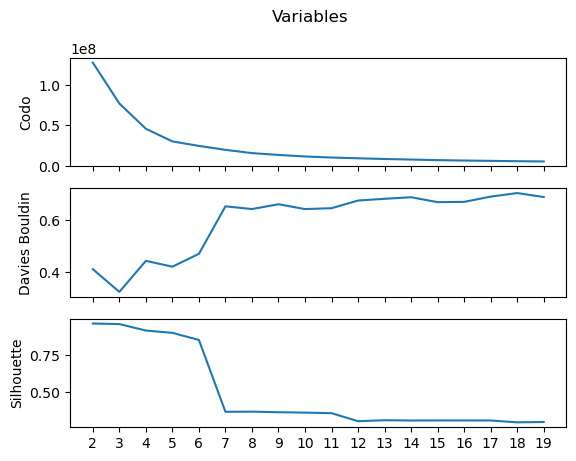

In [13]:
fig, axs = plt.subplots(3,sharex=True)
fig.suptitle('Variables')
axs[0].plot(range(ran1,ran2), wcss)
axs[0].set_ylabel('Codo')
axs[1].plot(range(ran1,ran2), dbs)
axs[1].set_ylabel('Davies Bouldin')
axs[2].plot(range(ran1,ran2), silh)
axs[2].set_ylabel('Silhouette')
plt.xticks(range(ran1,ran2))
plt.show()

In [23]:
kmeans = KMeans(3, init = 'k-means++', random_state = 42) #Basado en los gráficos
kmeans.fit(df[['std','kur','skewt','skewf','pkfreq','prfreq']].values)
labels = kmeans.labels_
df['cluster']=labels

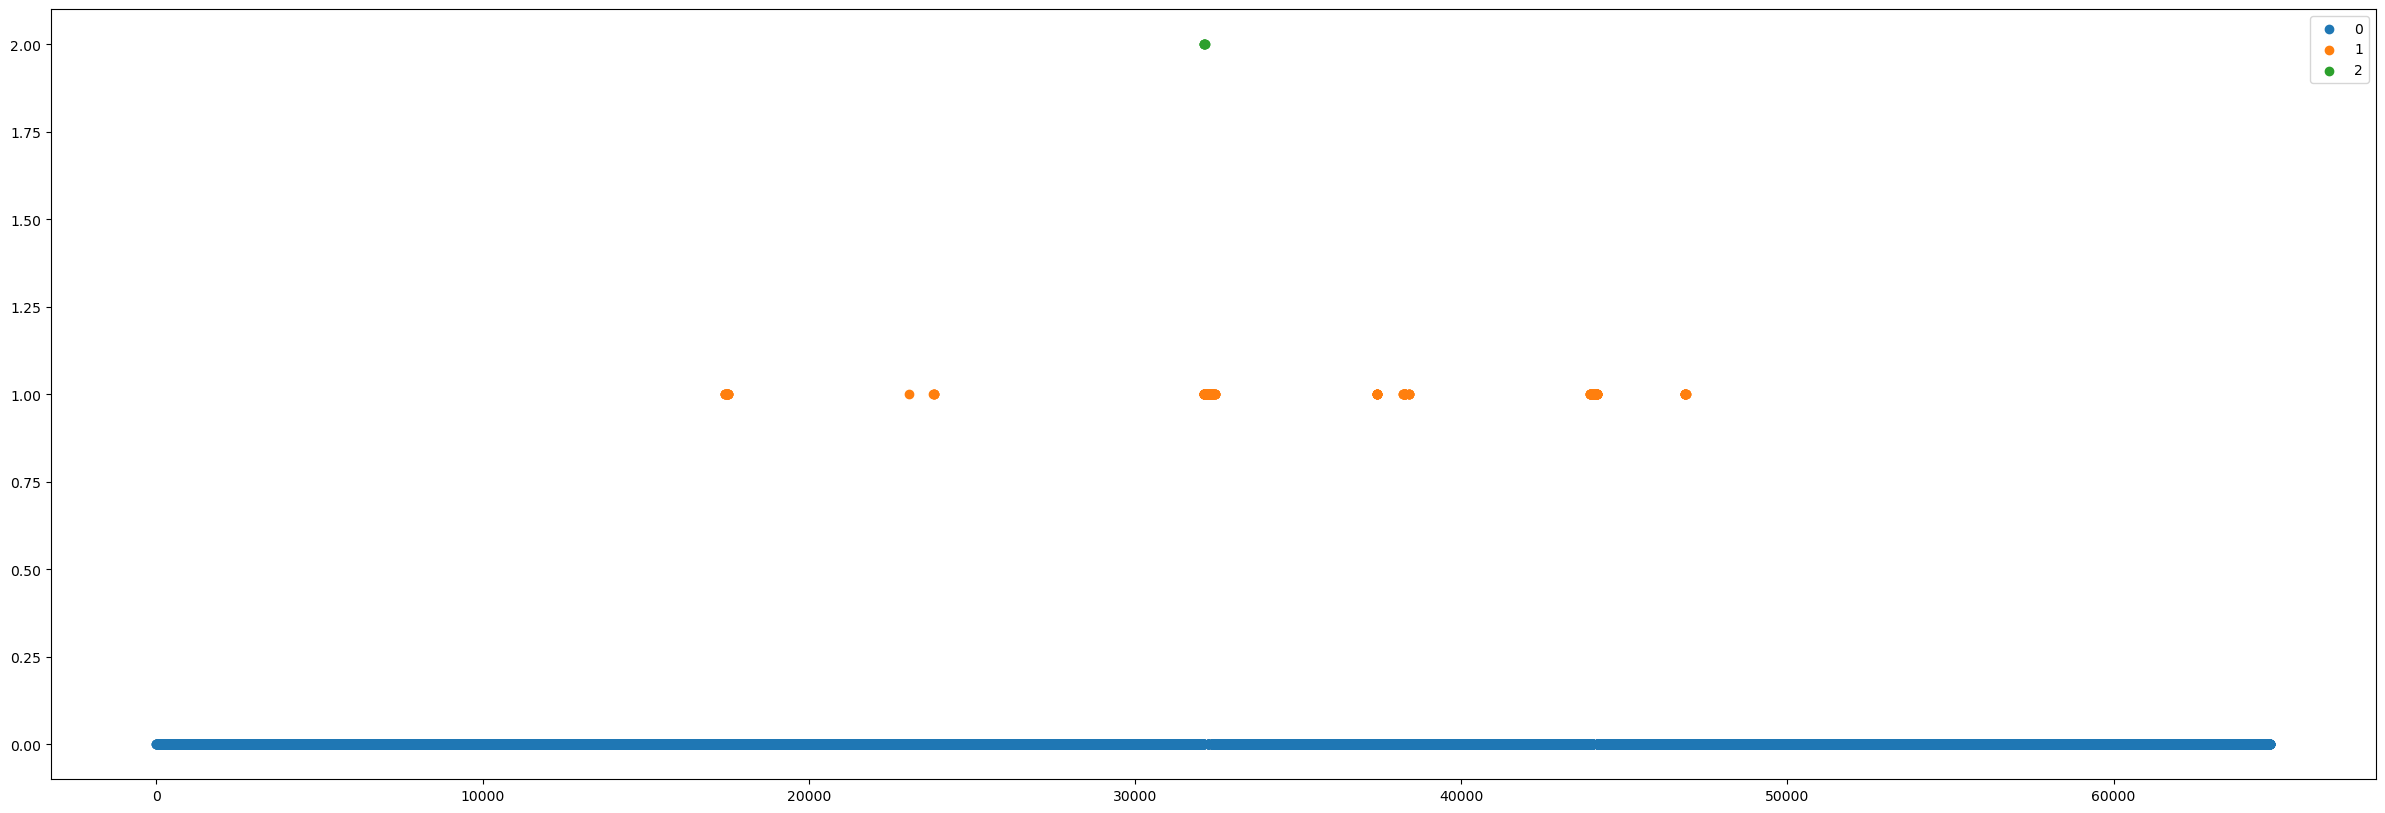

In [46]:
#Familias x tiempo
plt.figure(figsize=(30,10))
for i in df['cluster'].unique():
    df1=df[df['cluster']==i]
    plt.scatter(df1.index,df1['cluster'],label=str(i))
plt.legend()

In [25]:
#Agrupacion por hora
hour=((3600/tr.stats.delta)/ovlp)-1
ran1=0
ran2=hour
ls_stats_hour=[]
for i in range(int((len(all))/((3600/tr.stats.delta)/ovlp))):
    df1=df.iloc[int(ran1):int(ran2+1),-1]
    ls_stats_hour.append(df1.value_counts().rename(i))
    ran1+=hour
    ran2+=hour
stats=pd.concat(ls_stats_hour,axis=1)
stats=stats.replace(np.nan,0)

In [26]:
init=11
ls=[0]
for i in range(19):
    ls.append(init)
    init=init+12

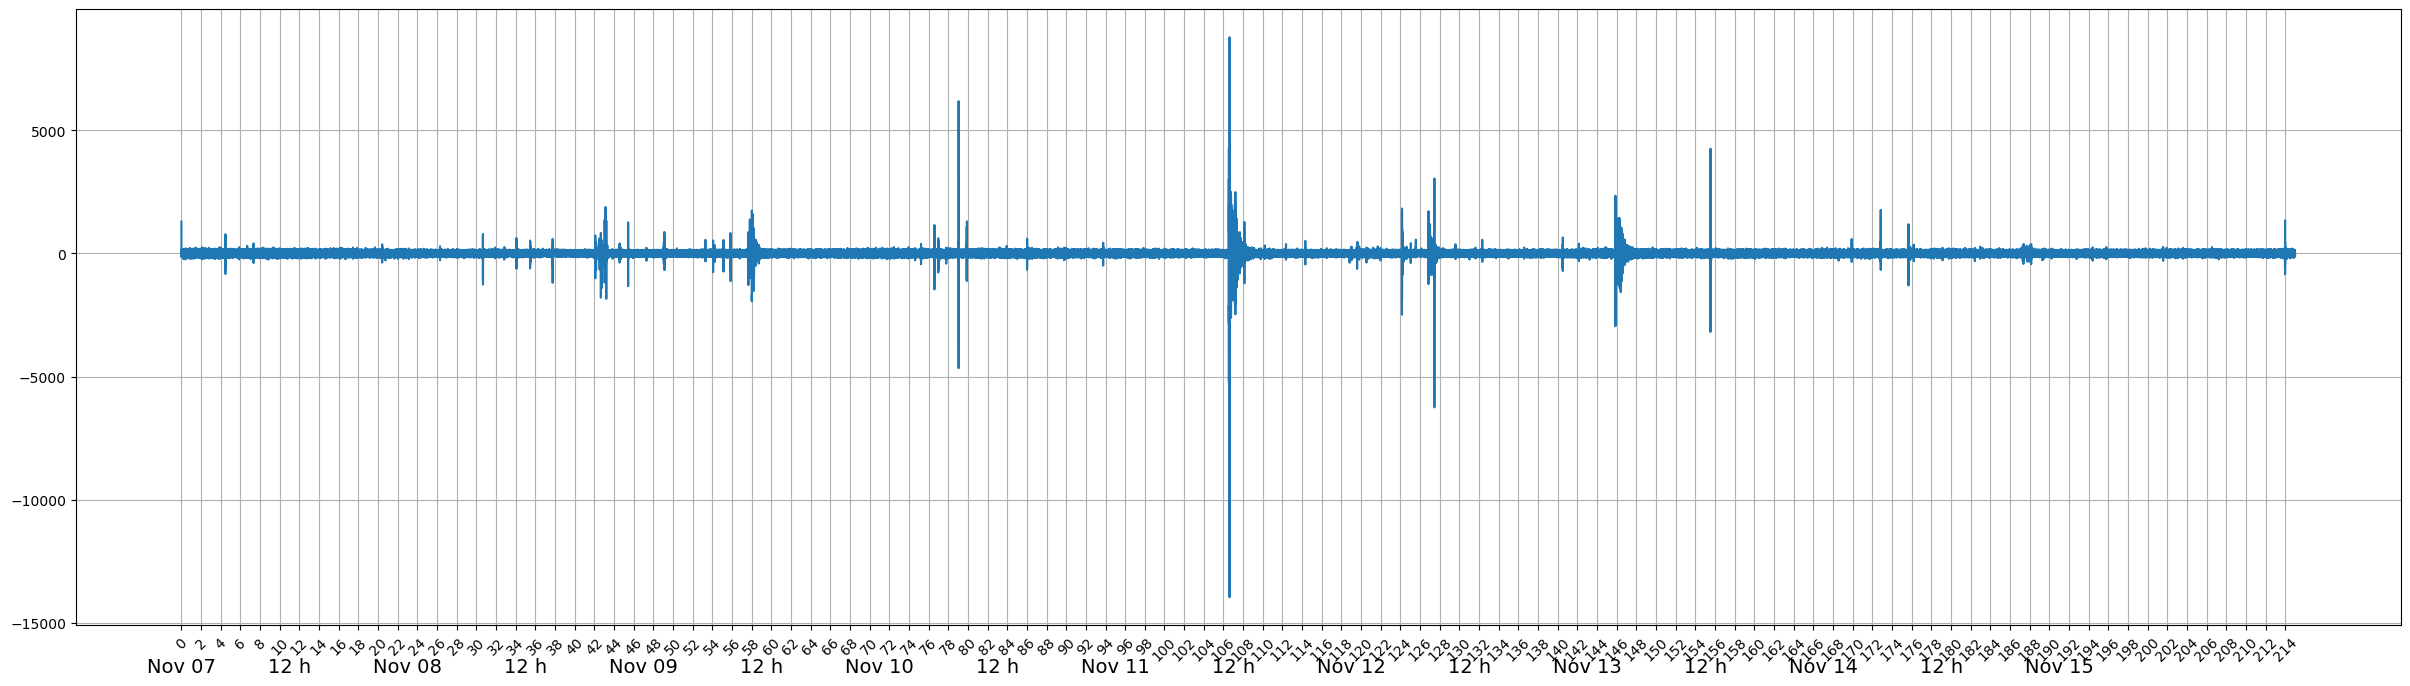

In [43]:
#Señal cruda
plt.figure(figsize=(30,8))
plt.plot(np.linspace(0,stats.columns[-1],len(tr.data))[0:-1:24],tr.data[0:-1:24])
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Nov 07','12 h','Nov 08','12 h','Nov 09','12 h','Nov 10','12 h','Nov 11','12 h','Nov 12','12 h','Nov 13','12 h','Nov 14','12 h','Nov 15'],ls):
    plt.text(x, -17000, str(i), size=14, ha='center')
plt.grid()
plt.show()

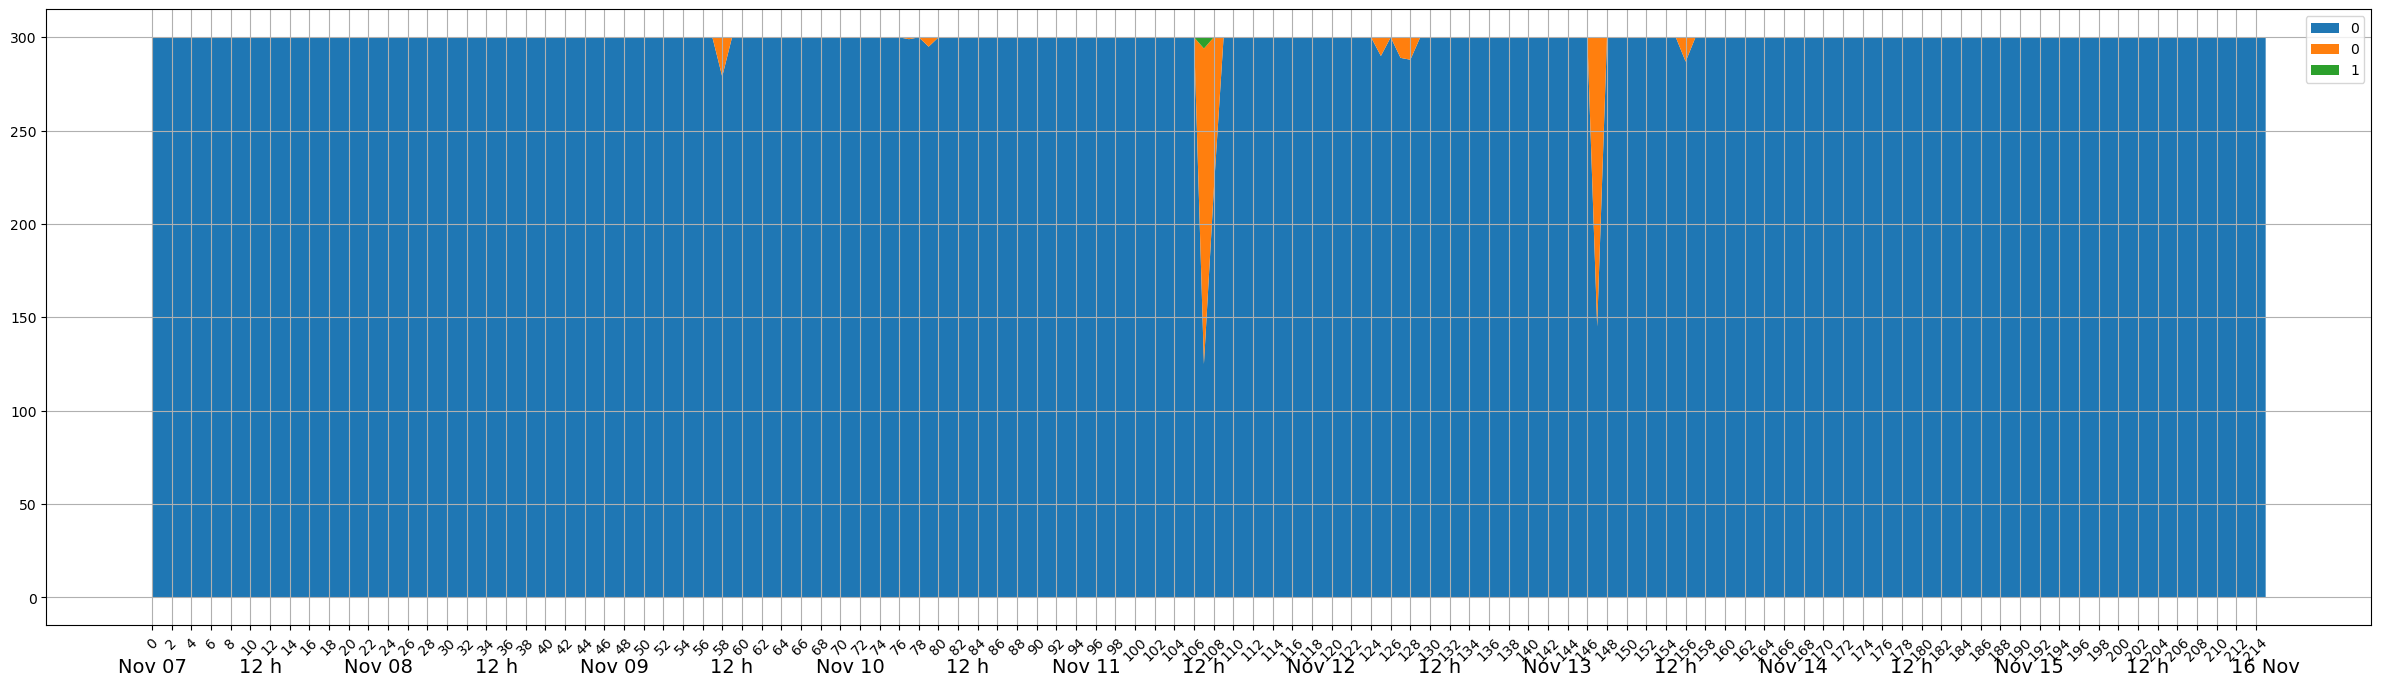

In [28]:
#% de cada familia x hora
plt.figure(figsize=(30,8))
plt.fill_between(stats.columns,stats.values[0],0,label='0')
for i,idx in zip(range(1,len(stats.values)),stats.index):
    plt.fill_between(stats.columns,np.sum(stats.values[0:i+1],axis=0),np.sum(stats.values[0:i],axis=0),label=str(idx))
plt.xticks(stats.columns[0:-1:2],rotation=45)
for i, x in zip(['Nov 07','12 h','Nov 08','12 h','Nov 09','12 h','Nov 10','12 h','Nov 11','12 h','Nov 12','12 h','Nov 13','12 h','Nov 14','12 h','Nov 15','12 h','16 Nov'],ls):
    plt.text(x, -40, str(i), size=14, ha='center')
plt.grid()
plt.legend()
plt.show()

Text(0, 0.5, 'prfreq')

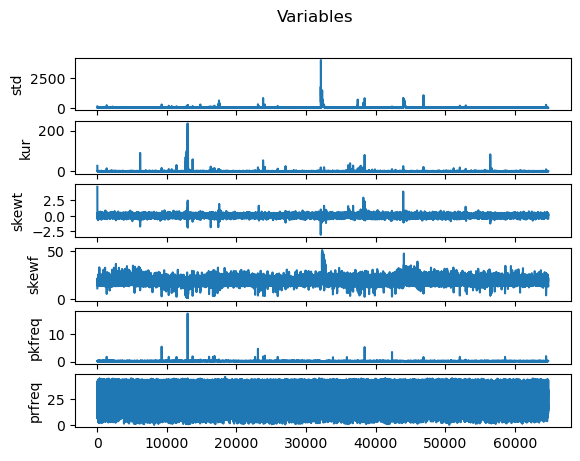

In [29]:
# Variables a lo largo del tiempo
fig, axs = plt.subplots(6,sharex=True)
fig.suptitle('Variables')
axs[0].plot(descr[:,1])
axs[0].set_ylabel('std')
axs[1].plot(descr[:,2])
axs[1].set_ylabel('kur')
axs[2].plot(descr[:,3])
axs[2].set_ylabel('skewt')
axs[3].plot(descr[:,4])
axs[3].set_ylabel('skewf')
axs[4].plot(descr[:,5])
axs[4].set_ylabel('pkfreq')
axs[5].plot(descr[:,6])
axs[5].set_ylabel('prfreq')

In [30]:
for i in [ 'std', 'kur', 'skewt', 'skewf', 'pkfreq', 'prfreq']:
    df[i]=df[i].astype(float)
ls_sim=[]
for i in df['cluster'].unique():
    df1=df[df['cluster']==i]
    sim=[]
    patron=df1.describe().iloc[1,:-1].values
    for i in df1[[ 'std', 'kur', 'skewt', 'skewf', 'pkfreq', 'prfreq']].values:
        sim.append(dot(patron, i)/(norm(patron)*norm(i))) #Similitud basada en los descriptores de la familia y de cada segmento
        #https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
    df1['similarity']=sim
    ls_sim.append(df1)

C:\Users\jujim\AppData\Local\Temp\ipykernel_14600\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['similarity']=sim
C:\Users\jujim\AppData\Local\Temp\ipykernel_14600\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['similarity']=sim
C:\Users\jujim\AppData\Local\Temp\ipykernel_14600\3663590319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

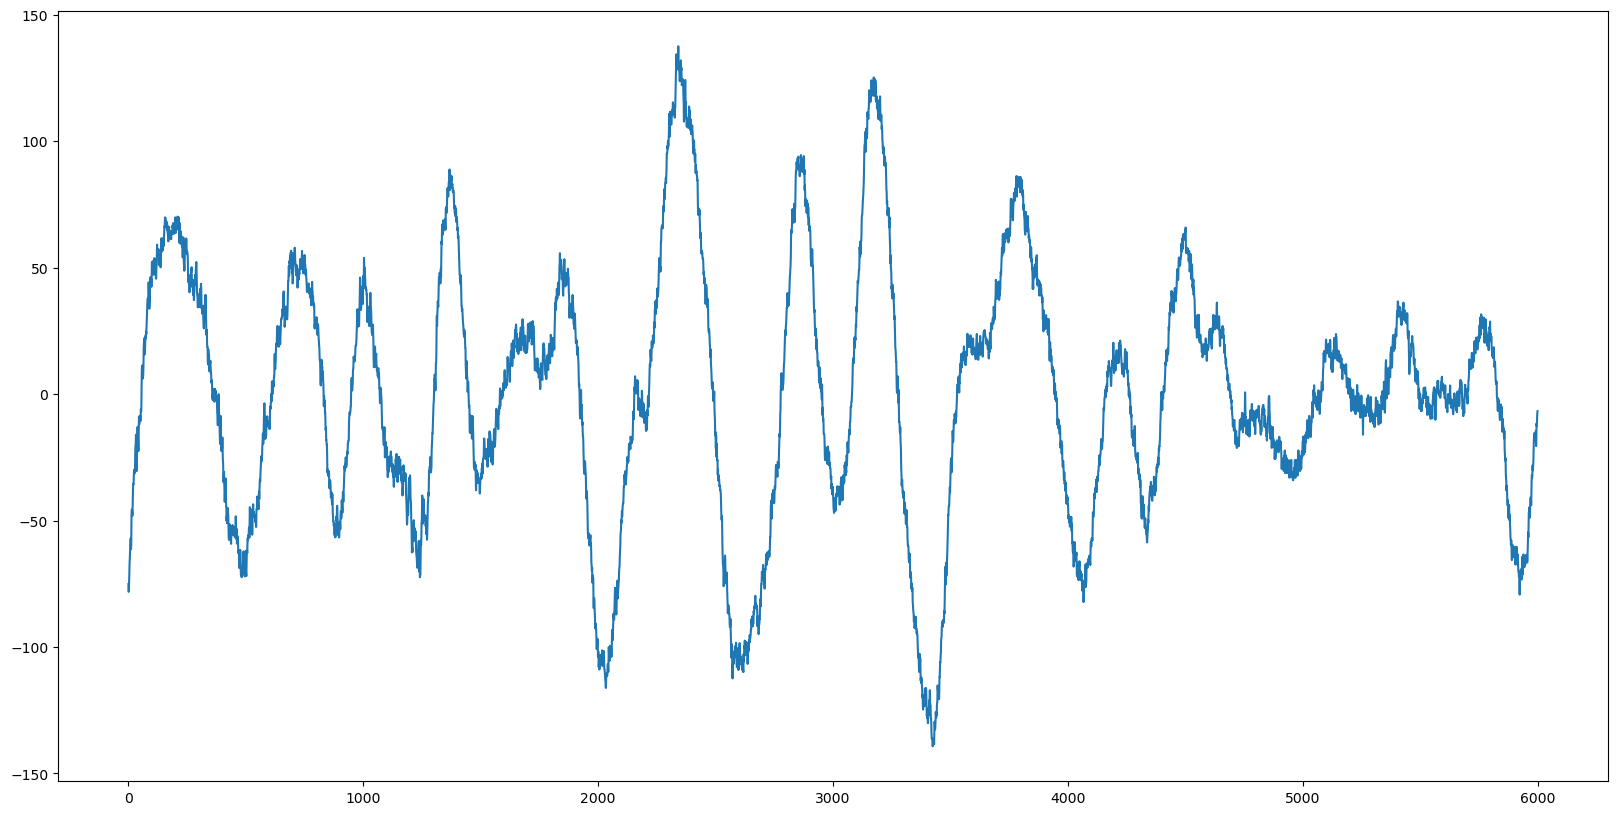

In [37]:
#Señal madre del cluster 0
plt.figure(figsize=(20,10))
plt.plot(ls_sim[0].sort_values(by='similarity',ascending=False).iloc[0,0])

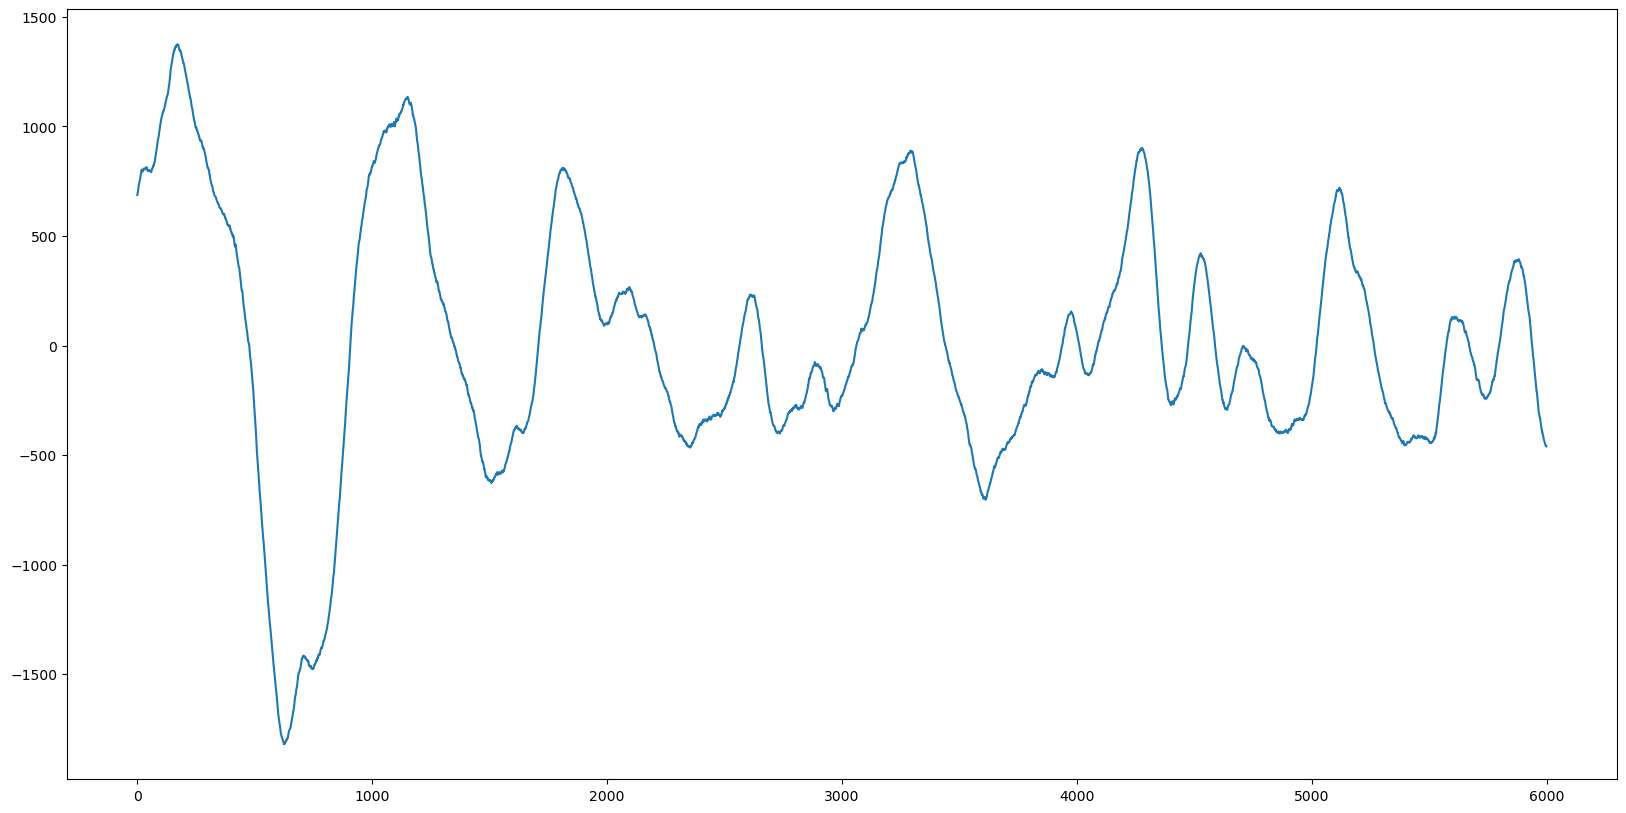

In [38]:
#Señal madre del cluster 1
plt.figure(figsize=(20,10))
plt.plot(ls_sim[1].sort_values(by='similarity',ascending=False).iloc[0,0])

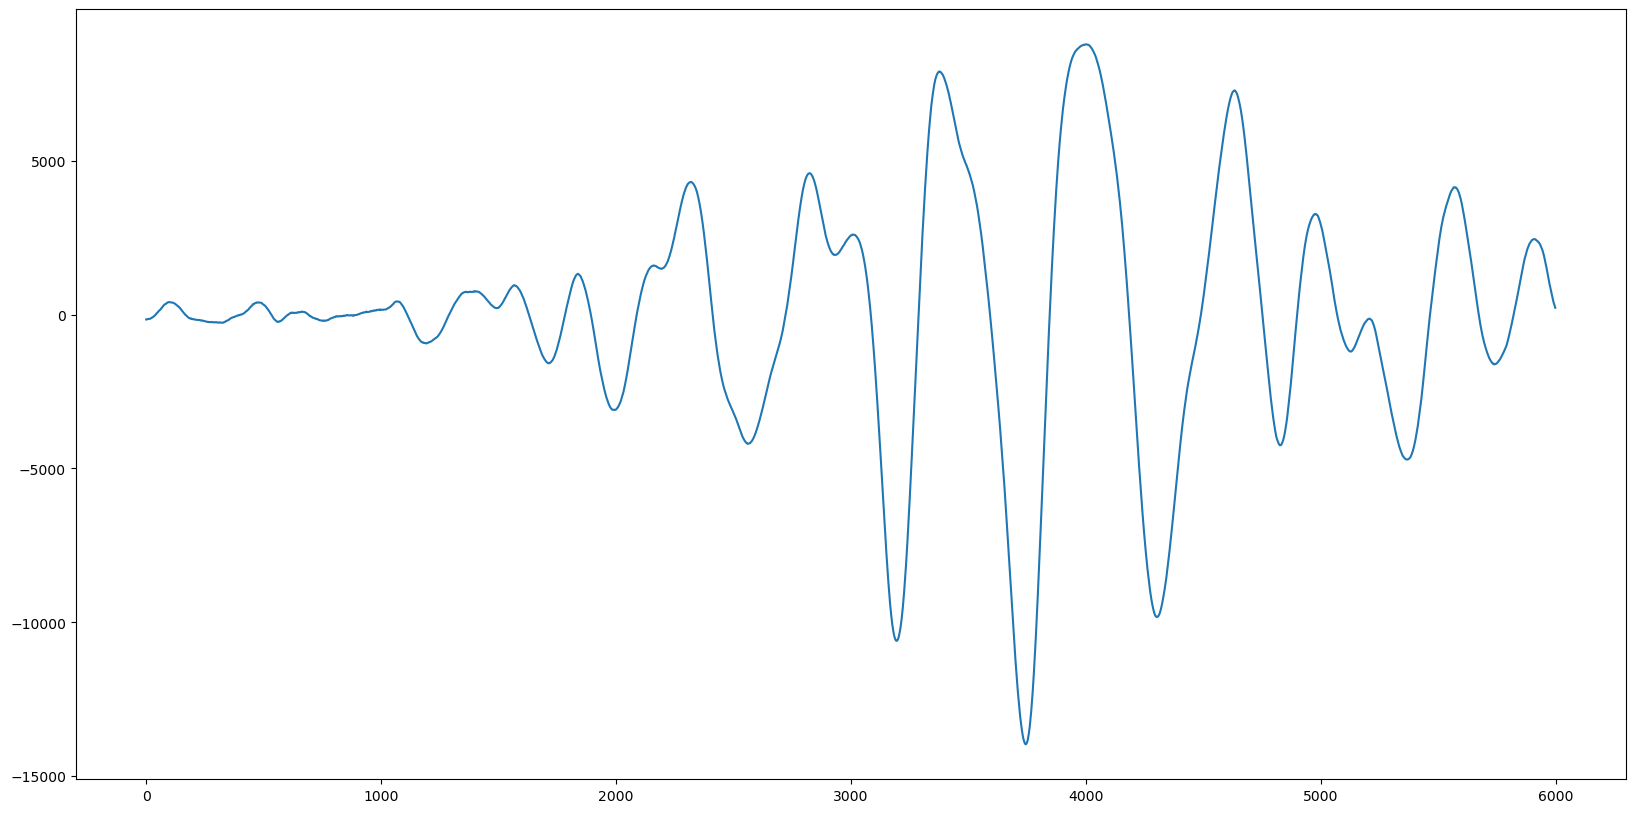

In [39]:
#Señal madre del cluster 2
plt.figure(figsize=(20,10))
plt.plot(ls_sim[2].sort_values(by='similarity',ascending=False).iloc[0,0])

## Referencias

-   Watson, L. M. (2020). Using unsupervised machine learning  to identify changes in eruptive behavior at Mount Etna, Italy.  Journal of Volcanology and Geothermal Research, 405, 107042.
-   https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists
-   http://sismo.sgc.gov.co:8080/fdsnws/dataselect/1/builder
-   https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad